In [35]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [36]:
# # Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomRotation(15),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        # Note the difference between (0.1307) and (0.1307,)
#                                        ])

# # Test Phase transformations
# test_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#                                        ])


In [37]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [38]:


train_transforms = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), always_apply=False, p=0.5),
        A.Resize(32, 32),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

In [39]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [40]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


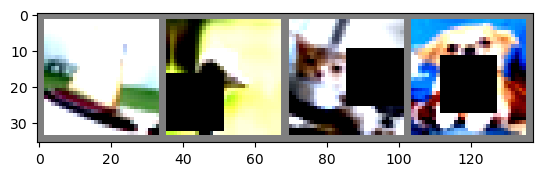

ship  bird  cat   dog  


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [43]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3/1

        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5/1

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1, stride=2, bias=False),
        ) # output_size = 16/7/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/11/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/15/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3) , padding=1, stride=2, bias=False),
        ) # output_size = 16/19/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 6/40/4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1/64

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)        
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [44]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]          18,432
           Conv2d-10           [-1, 64, 16, 16]          18,432
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1

You should consider upgrading via the 'I:\Installs\python.exe -m pip install --upgrade pip' command.


In [45]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [46]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.6144189834594727 Batch_id=97 Accuracy=32.30: 100%|██████████| 98/98 [00:11<00:00,  8.77it/s]



Test set: Average loss: 1.5152, Accuracy: 4468/10000 (44.68%)

EPOCH: 1


Loss=1.4960771799087524 Batch_id=97 Accuracy=45.59: 100%|██████████| 98/98 [00:11<00:00,  8.66it/s]



Test set: Average loss: 1.2805, Accuracy: 5304/10000 (53.04%)

EPOCH: 2


Loss=1.2451896667480469 Batch_id=97 Accuracy=52.44: 100%|██████████| 98/98 [00:11<00:00,  8.58it/s]



Test set: Average loss: 1.1329, Accuracy: 5829/10000 (58.29%)

EPOCH: 3


Loss=1.147187352180481 Batch_id=97 Accuracy=56.46: 100%|██████████| 98/98 [00:11<00:00,  8.58it/s] 



Test set: Average loss: 0.9823, Accuracy: 6467/10000 (64.67%)

EPOCH: 4


Loss=1.131413221359253 Batch_id=97 Accuracy=59.88: 100%|██████████| 98/98 [00:11<00:00,  8.39it/s] 



Test set: Average loss: 0.9810, Accuracy: 6510/10000 (65.10%)

EPOCH: 5


Loss=0.9329739809036255 Batch_id=97 Accuracy=62.51: 100%|██████████| 98/98 [00:11<00:00,  8.60it/s]



Test set: Average loss: 0.9222, Accuracy: 6740/10000 (67.40%)

EPOCH: 6


Loss=0.9017565846443176 Batch_id=97 Accuracy=64.90: 100%|██████████| 98/98 [00:11<00:00,  8.91it/s]



Test set: Average loss: 0.8231, Accuracy: 7105/10000 (71.05%)

EPOCH: 7


Loss=0.921308159828186 Batch_id=97 Accuracy=66.34: 100%|██████████| 98/98 [00:10<00:00,  9.02it/s] 



Test set: Average loss: 0.7971, Accuracy: 7218/10000 (72.18%)

EPOCH: 8


Loss=0.9054617285728455 Batch_id=97 Accuracy=67.84: 100%|██████████| 98/98 [00:11<00:00,  8.89it/s]



Test set: Average loss: 0.7288, Accuracy: 7407/10000 (74.07%)

EPOCH: 9


Loss=0.8485005497932434 Batch_id=97 Accuracy=69.45: 100%|██████████| 98/98 [00:11<00:00,  8.85it/s]



Test set: Average loss: 0.7246, Accuracy: 7483/10000 (74.83%)

EPOCH: 10


Loss=0.8054728507995605 Batch_id=97 Accuracy=70.38: 100%|██████████| 98/98 [00:10<00:00,  8.94it/s]



Test set: Average loss: 0.7012, Accuracy: 7598/10000 (75.98%)

EPOCH: 11


Loss=0.8592133522033691 Batch_id=97 Accuracy=70.94: 100%|██████████| 98/98 [00:10<00:00,  9.00it/s]



Test set: Average loss: 0.6416, Accuracy: 7737/10000 (77.37%)

EPOCH: 12


Loss=0.7769782543182373 Batch_id=97 Accuracy=72.02: 100%|██████████| 98/98 [00:10<00:00,  9.10it/s]



Test set: Average loss: 0.6281, Accuracy: 7841/10000 (78.41%)

EPOCH: 13


Loss=0.8462313413619995 Batch_id=97 Accuracy=72.62: 100%|██████████| 98/98 [00:11<00:00,  8.80it/s]



Test set: Average loss: 0.6255, Accuracy: 7825/10000 (78.25%)

EPOCH: 14


Loss=0.7137789130210876 Batch_id=97 Accuracy=73.73: 100%|██████████| 98/98 [00:11<00:00,  8.82it/s]



Test set: Average loss: 0.5801, Accuracy: 8021/10000 (80.21%)

EPOCH: 15


Loss=0.7218376398086548 Batch_id=97 Accuracy=74.02: 100%|██████████| 98/98 [00:10<00:00,  9.00it/s]



Test set: Average loss: 0.5780, Accuracy: 7987/10000 (79.87%)

EPOCH: 16


Loss=0.702652633190155 Batch_id=97 Accuracy=74.75: 100%|██████████| 98/98 [00:11<00:00,  8.84it/s] 



Test set: Average loss: 0.5527, Accuracy: 8131/10000 (81.31%)

EPOCH: 17


Loss=0.7733638286590576 Batch_id=97 Accuracy=75.19: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]



Test set: Average loss: 0.5872, Accuracy: 8005/10000 (80.05%)

EPOCH: 18


Loss=0.762365996837616 Batch_id=97 Accuracy=75.60: 100%|██████████| 98/98 [00:11<00:00,  8.86it/s] 



Test set: Average loss: 0.5463, Accuracy: 8147/10000 (81.47%)

EPOCH: 19


Loss=0.6891562342643738 Batch_id=97 Accuracy=75.81: 100%|██████████| 98/98 [00:11<00:00,  8.88it/s]



Test set: Average loss: 0.5358, Accuracy: 8168/10000 (81.68%)

EPOCH: 20


Loss=0.7472726106643677 Batch_id=97 Accuracy=76.27: 100%|██████████| 98/98 [00:11<00:00,  8.65it/s]



Test set: Average loss: 0.5355, Accuracy: 8150/10000 (81.50%)

EPOCH: 21


Loss=0.689731776714325 Batch_id=97 Accuracy=76.37: 100%|██████████| 98/98 [00:11<00:00,  8.69it/s] 



Test set: Average loss: 0.5565, Accuracy: 8130/10000 (81.30%)

EPOCH: 22


Loss=0.6738869547843933 Batch_id=97 Accuracy=77.11: 100%|██████████| 98/98 [00:11<00:00,  8.70it/s]



Test set: Average loss: 0.5210, Accuracy: 8212/10000 (82.12%)

EPOCH: 23


Loss=0.6429935693740845 Batch_id=97 Accuracy=77.56: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s]



Test set: Average loss: 0.5220, Accuracy: 8215/10000 (82.15%)

EPOCH: 24


Loss=0.6374840140342712 Batch_id=97 Accuracy=77.75: 100%|██████████| 98/98 [00:10<00:00,  8.93it/s]



Test set: Average loss: 0.4871, Accuracy: 8332/10000 (83.32%)

EPOCH: 25


Loss=0.6687406897544861 Batch_id=97 Accuracy=77.80: 100%|██████████| 98/98 [00:10<00:00,  8.98it/s]



Test set: Average loss: 0.4844, Accuracy: 8357/10000 (83.57%)

EPOCH: 26


Loss=0.5335444808006287 Batch_id=97 Accuracy=78.52: 100%|██████████| 98/98 [00:11<00:00,  8.87it/s]



Test set: Average loss: 0.4852, Accuracy: 8348/10000 (83.48%)

EPOCH: 27


Loss=0.5627772212028503 Batch_id=97 Accuracy=78.81: 100%|██████████| 98/98 [00:10<00:00,  8.97it/s]



Test set: Average loss: 0.4668, Accuracy: 8412/10000 (84.12%)

EPOCH: 28


Loss=0.52403724193573 Batch_id=97 Accuracy=78.76: 100%|██████████| 98/98 [00:10<00:00,  9.16it/s]  



Test set: Average loss: 0.4694, Accuracy: 8407/10000 (84.07%)

EPOCH: 29


Loss=0.5370755195617676 Batch_id=97 Accuracy=78.82: 100%|██████████| 98/98 [00:11<00:00,  8.87it/s]



Test set: Average loss: 0.4500, Accuracy: 8472/10000 (84.72%)

EPOCH: 30


Loss=0.6264744400978088 Batch_id=97 Accuracy=79.08: 100%|██████████| 98/98 [00:10<00:00,  8.98it/s]



Test set: Average loss: 0.4512, Accuracy: 8466/10000 (84.66%)

EPOCH: 31


Loss=0.5957049131393433 Batch_id=97 Accuracy=79.37: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s] 



Test set: Average loss: 0.4447, Accuracy: 8479/10000 (84.79%)

EPOCH: 32


Loss=0.5915079712867737 Batch_id=97 Accuracy=79.75: 100%|██████████| 98/98 [00:11<00:00,  8.60it/s] 



Test set: Average loss: 0.4383, Accuracy: 8532/10000 (85.32%)

EPOCH: 33


Loss=0.5866948962211609 Batch_id=97 Accuracy=79.76: 100%|██████████| 98/98 [00:10<00:00,  8.95it/s]



Test set: Average loss: 0.4337, Accuracy: 8534/10000 (85.34%)

EPOCH: 34


Loss=0.5945529937744141 Batch_id=97 Accuracy=79.91: 100%|██████████| 98/98 [00:10<00:00,  9.03it/s] 



Test set: Average loss: 0.4390, Accuracy: 8508/10000 (85.08%)

EPOCH: 35


Loss=0.6318964958190918 Batch_id=97 Accuracy=80.16: 100%|██████████| 98/98 [00:11<00:00,  8.86it/s] 



Test set: Average loss: 0.4308, Accuracy: 8550/10000 (85.50%)

EPOCH: 36


Loss=0.634609043598175 Batch_id=97 Accuracy=80.22: 100%|██████████| 98/98 [00:11<00:00,  8.36it/s]  



Test set: Average loss: 0.4372, Accuracy: 8524/10000 (85.24%)

EPOCH: 37


Loss=0.5838307738304138 Batch_id=97 Accuracy=80.64: 100%|██████████| 98/98 [00:11<00:00,  8.55it/s] 



Test set: Average loss: 0.4257, Accuracy: 8588/10000 (85.88%)

EPOCH: 38


Loss=0.5544014573097229 Batch_id=97 Accuracy=80.57: 100%|██████████| 98/98 [00:11<00:00,  8.81it/s] 



Test set: Average loss: 0.4256, Accuracy: 8554/10000 (85.54%)

EPOCH: 39


Loss=0.5465688109397888 Batch_id=97 Accuracy=80.87: 100%|██████████| 98/98 [00:11<00:00,  8.89it/s] 



Test set: Average loss: 0.4217, Accuracy: 8563/10000 (85.63%)

EPOCH: 40


Loss=0.5347045063972473 Batch_id=97 Accuracy=80.79: 100%|██████████| 98/98 [00:11<00:00,  8.86it/s] 



Test set: Average loss: 0.4279, Accuracy: 8559/10000 (85.59%)

EPOCH: 41


Loss=0.5344662070274353 Batch_id=97 Accuracy=81.08: 100%|██████████| 98/98 [00:11<00:00,  8.86it/s] 



Test set: Average loss: 0.4211, Accuracy: 8595/10000 (85.95%)

EPOCH: 42


Loss=0.4906304180622101 Batch_id=97 Accuracy=81.24: 100%|██████████| 98/98 [00:11<00:00,  8.83it/s] 



Test set: Average loss: 0.4071, Accuracy: 8655/10000 (86.55%)

EPOCH: 43


Loss=0.5169367790222168 Batch_id=97 Accuracy=81.23: 100%|██████████| 98/98 [00:11<00:00,  8.44it/s] 



Test set: Average loss: 0.4122, Accuracy: 8627/10000 (86.27%)

EPOCH: 44


Loss=0.4898338317871094 Batch_id=97 Accuracy=81.66: 100%|██████████| 98/98 [00:11<00:00,  8.66it/s] 



Test set: Average loss: 0.4064, Accuracy: 8642/10000 (86.42%)

EPOCH: 45


Loss=0.5701926350593567 Batch_id=97 Accuracy=81.60: 100%|██████████| 98/98 [00:11<00:00,  8.74it/s] 



Test set: Average loss: 0.4251, Accuracy: 8576/10000 (85.76%)

EPOCH: 46


Loss=0.5306045413017273 Batch_id=97 Accuracy=81.60: 100%|██████████| 98/98 [00:11<00:00,  8.64it/s] 



Test set: Average loss: 0.4001, Accuracy: 8662/10000 (86.62%)

EPOCH: 47


Loss=0.5457931756973267 Batch_id=97 Accuracy=81.84: 100%|██████████| 98/98 [00:11<00:00,  8.66it/s] 



Test set: Average loss: 0.4042, Accuracy: 8630/10000 (86.30%)

EPOCH: 48


Loss=0.5603201985359192 Batch_id=97 Accuracy=82.13: 100%|██████████| 98/98 [00:10<00:00,  8.96it/s] 



Test set: Average loss: 0.4025, Accuracy: 8660/10000 (86.60%)

EPOCH: 49


Loss=0.4940059185028076 Batch_id=97 Accuracy=81.99: 100%|██████████| 98/98 [00:11<00:00,  8.86it/s] 



Test set: Average loss: 0.4032, Accuracy: 8650/10000 (86.50%)

